<a href="https://colab.research.google.com/github/kabilankarunakaran/gan/blob/master/Gan_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn as nn
import cv2
import torchvision.utils as vutils
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import numpy as np
%matplotlib inline

In [2]:
os.getcwd()

'/content'

In [3]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [4]:
datadir = '/content/cats'

In [7]:
print(os.listdir(datadir+'/cats'))

['15018.jpg', '744.jpg', '51.jpg', '6976.jpg', '14389.jpg', '15515.jpg', '14920.jpg', '14455.jpg', '3787.jpg', '9660.jpg', '5483.jpg', '14234.jpg', '2199.jpg', '15542.jpg', '14793.jpg', '14738.jpg', '1692.jpg', '7068.jpg', '6270.jpg', '1993.jpg', '12932.jpg', '13950.jpg', '8158.jpg', '13861.jpg', '14982.jpg', '4889.jpg', '1448.jpg', '6494.jpg', '10291.jpg', '15670.jpg', '11949.jpg', '6154.jpg', '7894.jpg', '2837.jpg', '7770.jpg', '9524.jpg', '15293.jpg', '10096.jpg', '8376.jpg', '6763.jpg', '15095.jpg', '8948.jpg', '2663.jpg', '15159.jpg', '9889.jpg', '14765.jpg', '12433.jpg', '8691.jpg', '2354.jpg', '11888.jpg', '7800.jpg', '11149.jpg', '3355.jpg', '498.jpg', '6388.jpg', '3328.jpg', '5544.jpg', '6654.jpg', '14976.jpg', '13942.jpg', '11172.jpg', '7221.jpg', '2035.jpg', '5976.jpg', '8234.jpg', '15534.jpg', '1544.jpg', '2294.jpg', '4043.jpg', '6617.jpg', '13629.jpg', '3324.jpg', '9947.jpg', '13527.jpg', '8128.jpg', '4019.jpg', '12376.jpg', '4248.jpg', '6490.jpg', '3509.jpg', '2166.jpg', 

In [12]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

train_ds = ImageFolder(datadir, transform = tt.Compose([tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 3, pin_memory= True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


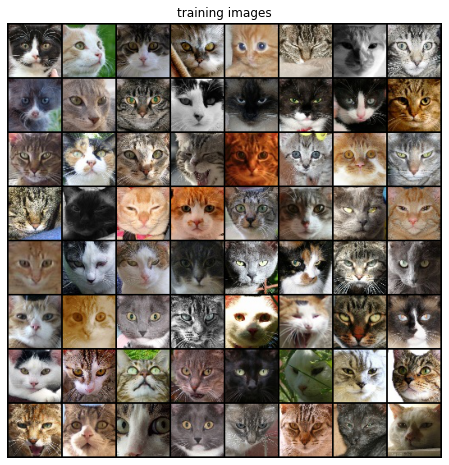

In [30]:
realbatch = next(iter(train_dl))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("training images")
plt.imshow(np.transpose(vutils.make_grid(realbatch[0].to(device)[:64],padding=2,normalize = True).cpu(),(1,2,0)))

In [36]:
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1  = 0.5


In [37]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data,0.0,0.2)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0) 

In [40]:

#build generator model

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.main =  nn.Sequential(
    #in latent size * 1 * 1

    nn.ConvTranspose2d(nz, 512, kernel_size = 4,stride = 1,padding = 0,bias = True),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size = 4,stride = 1,padding = 0,bias = True),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size = 4,stride = 1,padding = 0,bias = True),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size = 4,stride = 1,padding = 0,bias = True),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size = 4,stride = 1,padding = 0,bias = True),
    nn.Tanh()
    )
    

    def forward(self,input):
      return self.main(input)


In [42]:
netG= Generator()
netG.apply(weight_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(1, 1))
    (13): Tanh()
  )
)
